In [7]:
import os
import torch
import trimesh
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

In [8]:
root_dir = 'datasets/human/'  # Change this to your actual dataset path
save_dir = 'models/simple_pointnet/'
num_points = 1024  # Predefined row length (number of rows to keep)
learning_rate = 0.001
batch_size = 32
num_epochs = 5

In [9]:
def mesh_to_pointcloud(mesh, num_points=1024, normalize=True):
    """Convert a trimesh mesh object to a point cloud."""
    point_cloud = mesh.sample(num_points)  # Randomly sample points from mesh surface
    if normalize:
        point_cloud -= np.mean(point_cloud, axis=0)
        point_cloud /= np.max(np.linalg.norm(point_cloud, axis=1))
    return point_cloud.astype(np.float32)

class PointcloudDataset(Dataset):
    def __init__(self, root_dir, num_points=1024, transform=None):
        self.root_dir = root_dir
        self.num_points = num_points
        self.transform = transform
        self.samples = []

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                obj_files = [f for f in os.listdir(class_dir) if f.endswith('.obj')]
                for obj_file in obj_files:
                    obj_path = os.path.join(class_dir, obj_file)
                    label = class_name 
                    self.samples.append((obj_path, label))

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(set([s[1] for s in self.samples])))}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        obj_path, label = self.samples[idx]
        
        mesh = trimesh.load(obj_path)
        point_cloud = mesh_to_pointcloud(mesh, num_points=self.num_points, normalize=True)        
        
        label_idx = self.class_to_idx[label]

        if self.transform:
            point_cloud = self.transform(point_cloud)

        point_cloud_tensor = torch.tensor(point_cloud, dtype=torch.float32)
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        return point_cloud_tensor, label_tensor

In [10]:
class SimplePointNet(nn.Module):
    def __init__(self, num_classes, input_dim=3):
        """
        Args:
            num_classes (int): Number of output classes.
            input_dim (int): Dimension of the input point cloud (default is 3 for x, y, z).
        """
        super(SimplePointNet, self).__init__()

        # Input transformation MLP
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1024)

        # Batch normalization layers applied after the fully connected layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

        # Global feature vector aggregation
        self.maxpool = nn.MaxPool1d(1024)

        # Fully connected layers for classification
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, num_classes)

        # Batch normalization layers for the classification layers
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        # x: (batch_size, num_points, 3)
        batch_size = x.size(0)
        num_points = x.size(1)

        x = F.relu(self.fc1(x))  # (batch_size, num_points, 64)
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 64)
        
        x = F.relu(self.fc2(x))  # (batch_size, num_points, 128)
        x = self.bn2(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 128)
        
        x = F.relu(self.fc3(x))  # (batch_size, num_points, 1024)
        x = self.bn3(x.transpose(1, 2)).transpose(1, 2)  # (batch_size, num_points, 1024)

        x = x.permute(0, 2, 1)  # (batch_size, 1024, num_points)
        x = self.maxpool(x)  # (batch_size, 1024, 1)
        x = x.view(batch_size, -1)  # (batch_size, 1024)

        x = F.relu(self.bn4(self.fc4(x)))  # (batch_size, 512)
        x = F.relu(self.bn5(self.fc5(x)))  # (batch_size, 256)
        x = self.fc6(x)  # (batch_size, num_classes)

        return x

In [11]:
dataset = PointcloudDataset(root_dir, num_points=num_points)

dataset_size = len(dataset)
test_size = int(0.10 * dataset_size)
val_size = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(dataset.class_to_idx)

print(f'Number of samples: {len(dataset)}')
print(f'Classes: {dataset.class_to_idx}')
print(f'Number of classes: {len(dataset.class_to_idx)}')
for i, count in enumerate(np.bincount([dataset.class_to_idx[s[1]] for s in dataset.samples])):
    print(f'Class {i} - {dataset.idx_to_class[i]}: {count} samples')
print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))
print('Test size:', len(test_dataset))


model = SimplePointNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Number of samples: 1850
Classes: {'bouncing': 0, 'crane': 1, 'handstand': 2, 'jumping': 3, 'march_1': 4, 'march_2': 5, 'samba': 6, 'squat_1': 7, 'squat_2': 8}
Number of classes: 9
Class 0 - bouncing: 175 samples
Class 1 - crane: 175 samples
Class 2 - handstand: 175 samples
Class 3 - jumping: 150 samples
Class 4 - march_1: 250 samples
Class 5 - march_2: 250 samples
Class 6 - samba: 175 samples
Class 7 - squat_1: 250 samples
Class 8 - squat_2: 250 samples
Train size: 1388
Validation size: 277
Test size: 185


In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for point_clouds, labels in train_loader:
        outputs = model(point_clouds)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for point_clouds, labels in val_loader:
            outputs = model(point_clouds)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}, Validation Accuracy: {accuracy:.2f}%')
    
    torch.save(model.state_dict(), save_dir + f'/checkpoints/pointnet_{epoch}.pth')

torch.save(model.state_dict(), save_dir + 'pointnet.pth')

Epoch [1/5], Loss: 0.9166589386083863, Validation Accuracy: 15.88%
Epoch [2/5], Loss: 0.3019333779811859, Validation Accuracy: 90.61%
Epoch [3/5], Loss: 0.1857626899568872, Validation Accuracy: 92.06%
Epoch [4/5], Loss: 0.11508341247893193, Validation Accuracy: 96.75%
Epoch [5/5], Loss: 0.10356180890547959, Validation Accuracy: 97.11%


Test Accuracy: 98.38%


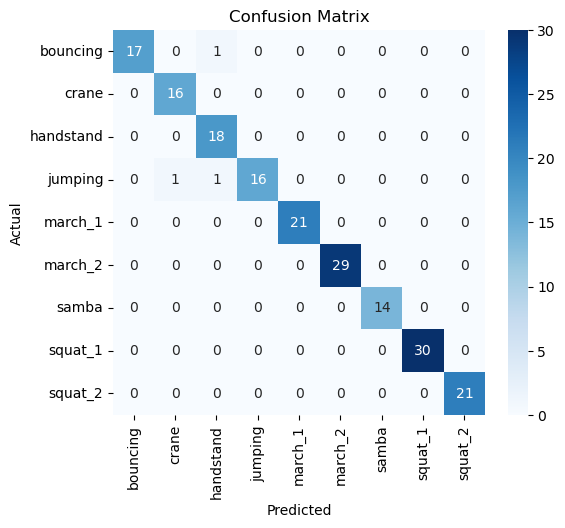

In [13]:
test_model = SimplePointNet(num_classes=num_classes)  
test_model.load_state_dict(torch.load(save_dir + 'pointnet.pth', weights_only=True))
test_model.eval()

correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for point_clouds, labels in test_loader:
        outputs = model(point_clouds)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=dataset.idx_to_class.values(), yticklabels=dataset.idx_to_class.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()